In [1]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

## Getting the data

In [2]:
train_data = datasets.FashionMNIST(root="data",
                                   train=True,
                                   download=True,
                                   transform=ToTensor(),
                                   target_transform=None)
test_data = datasets.FashionMNIST(root="data",
                                  train=False,
                                  download=True,
                                  transform=ToTensor())

100%|██████████| 26421880/26421880 [00:01<00:00, 13215735.63it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 233786.54it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3805874.50it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 12219737.97it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [3]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

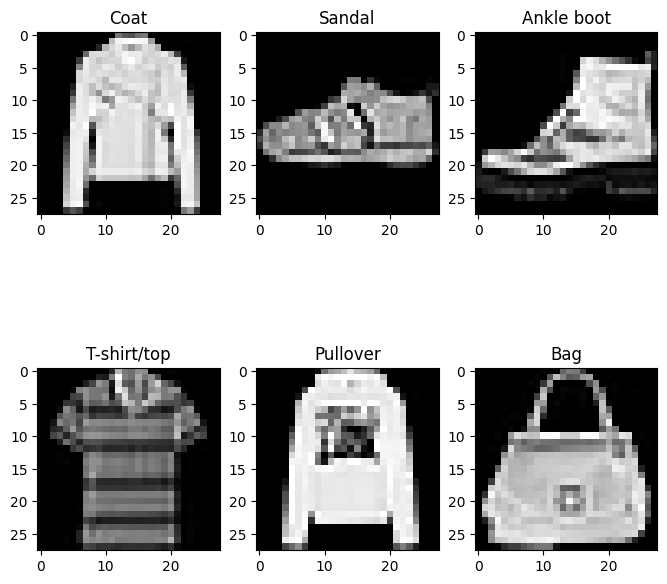

In [4]:
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(8,8))
cols, rows = 3, 2
for i in range(1, rows*cols + 1):
    random_idx = torch.randint(len(train_data), size=(1,)).item()
    image, label = train_data[random_idx]
    figure.add_subplot(rows, cols, i)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(class_names[label])

## Prepare a Dataloader

In [5]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

In [6]:
len(train_dataloader), len(test_dataloader)

(1875, 313)

## Create a Model

In [7]:
class FashionMNISTModelEx(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(f"Shape after Conv block 1: {x.shape}")
        x = self.block_2(x)
        # print(f"Shape after Conv block 2: {x.shape}")
        x = self.classifier(x)
        # print(f"Shape after classifier: {x.shape}")
        return x


# Instantiating the model
torch.manual_seed(42)

model_0 = FashionMNISTModelEx(input_shape=1,
                              hidden_units=10,
                              output_shape=len(class_names))
model_0

FashionMNISTModelEx(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

## Loss Function and Optimizer

In [8]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [9]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

## Training and Testing Loop

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [11]:
# Training Loop Function
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               optimizer: torch.optim.Optimizer,
               device: torch.device = device):
    # Send the model to device
    model.to(device)

    train_loss, train_acc = 0, 0
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train Loss: {train_loss:0.5f}, Train Accuracy: {train_acc:.2f}%")


# Testing Loop Function
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    # Send the model to device
    model.to(device)

    test_loss, test_acc = 0, 0
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)

        test_pred = model(X)

        test_loss += loss_fn(test_pred, y)
        test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))


    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Train Loss: {test_loss:0.5f}, Train Accuracy: {test_acc:.2f}%")


In [12]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---")
    train_step(model=model_0,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               accuracy_fn=accuracy_fn,
               optimizer=optimizer,
               device=device)
    test_step(model=model_0,
              data_loader=test_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---
Train Loss: 0.59518, Train Accuracy: 78.38%
Train Loss: 0.39500, Train Accuracy: 85.99%
Epoch: 1
---
Train Loss: 0.36536, Train Accuracy: 86.90%
Train Loss: 0.35244, Train Accuracy: 86.91%
Epoch: 2
---
Train Loss: 0.32588, Train Accuracy: 88.13%
Train Loss: 0.32719, Train Accuracy: 88.07%


## Evaluating the Model

In [13]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):

    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        loss /= len(data_loader)
        acc /= len(data_loader)

    return {'Model Name:': model.__class__.__name__,
            'Model Loss': loss.item(),
            'Model Acc': acc}


In [14]:
model_0_results = eval_model(model=model_0,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn,
                             device=device)
model_0_results

{'Model Name:': 'FashionMNISTModelEx',
 'Model Loss': 0.32718968391418457,
 'Model Acc': 88.06908945686901}

## Make Predictions

In [24]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
    pred_probs = []
    model.to(device)

    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0)

            # Forward Pass (model outputs raw logits)
            pred_logit = model(sample)

            # Get prediction probabilities
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob)

    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)


In [26]:
import random
random.seed(42)

test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# Make Predictions with make_predictions on test_samples
pred_probs = make_predictions(model=model_0,
                              data=test_samples)

pred_classes = pred_probs.argmax(dim=1)

test_labels, pred_classes

([5, 1, 7, 4, 3, 0, 4, 7, 1], tensor([5, 1, 7, 4, 3, 0, 4, 7, 1]))

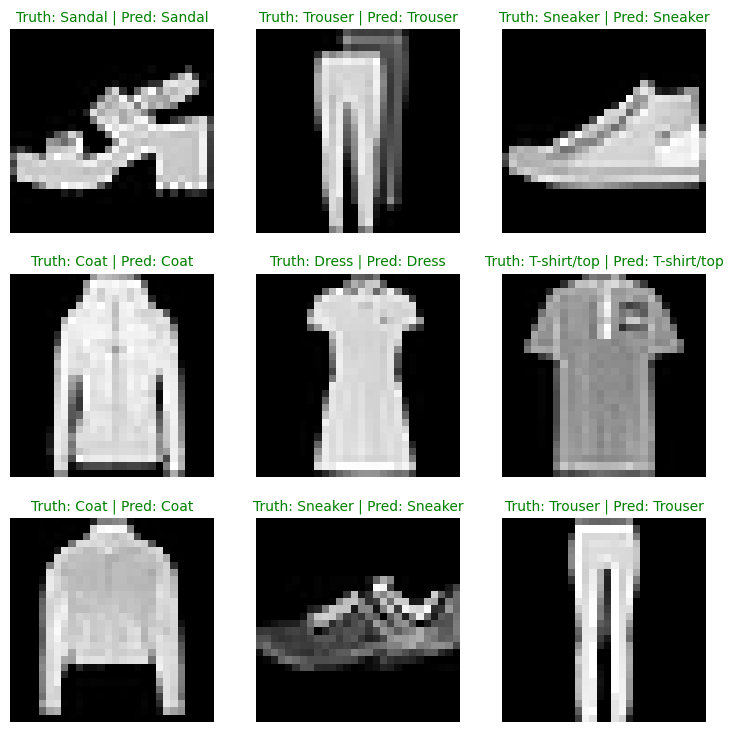

In [32]:
plt.figure(figsize=(9,9))
nrows = 3
ncols = 3

for i, sample in enumerate(test_samples):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(sample.squeeze(), cmap='gray')
    pred_label = class_names[pred_classes[i]]
    truth_label = class_names[test_labels[i]]
    title_text = f"Truth: {truth_label} | Pred: {pred_label}"

    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, color='g')
    else:
        plt.title(title_text, fontsize=10, color='r')
    plt.axis('off')
